In [37]:
from IPython.core.display import set_matplotlib_formats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cProfile import label
from scipy.io import arff
from scipy.stats import mode
import enum
np.random.seed(1234)


def task1():
    data3 = arff.loadarff('./sample_data/messidor_features.arff')
    data3 = pd.DataFrame(data3[0])
    col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
            'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
            ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
            'euc_dist','diam_opt_disc','AM/FM','class_label']
    data3.columns = col_names
    data3.class_label = data3.class_label.apply(lambda x: pd.to_numeric(str(x)[2]))
    data3 = data3.replace({'?' : np.nan}).dropna()
    # print(df.corr())
    # print(df)
    # basic statistics df
    # print(df.describe(include='all'))
    # Document messidor features.arff above
    # Document hepatitis below
    df2 = pd.read_csv('./sample_data/hepatitis1.csv', 
    names=["class", "age", "sex", "steroid", "antivirals", 
    "fatigue", "malaise", "anorexia", "liver_big", "liver_firm", 
    "spleen_palpable", "spiders", "ascites", "varices", "bilirubin", 
    "alk_phosphate", "sgot", "albumin", "protime", "histology"])
    df2 = df2.replace({'?': np.nan}).dropna()
    af = df2.select_dtypes(include="object")
    dic = {}
    for i in af:
      df2[i] = df2[i].astype(float, errors = "raise")
    df2.astype(dic).dtypes

    # print(df2.corr())
    # print(df2)
    # basic statistics df2
    # print(df2.describe(include='all'))

    # data3 = data3.to_numpy()
    # df2 = df2.to_numpy()
    # print(df[:, 18:]) # taking values that are besides 1 and 0
    # print(df2[:, 16:]) # taking values that are besides 1 and 0
    return data3, df2 # messidor and hep data respectively

class Node:
    def __init__(self,indices,parent):
      self.indices = indices
      self.left = None
      self.right = None
      self.split_feature = None
      self.split_value = None
      if parent:
        self.depth = parent.depth+1
        self.num_classes = parent.num_classes
        self.data = parent.data
        self.labels = parent.labels
        class_probs = np.bincount(self.labels[indices],minlength = self.num_classes)
        self.class_probs = class_probs/np.sum(class_probs)

def greedy_test(node,cost_func):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances,num_features = node.data.shape
    #sort the features to get the test value candidates 
    #taking avg of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.indices],axis=0)
    test_candidates = (data_sorted[1:]+data_sorted[:-1])/2.
    for f in range(num_features):
      data_f = node.data[node.indices,f]
      for test in test_candidates[:,f]:
          # store the data corresponding to the f-th feature
          left_ind = node.indices[data_f <= test]
          right_ind = node.indices[data_f > test]
          # stop splitting when the child has zero element
          if len(left_ind)==0 or len(right_ind)==0:
              continue
          #compute the left and right cost based on the current split
          left_cost = cost_func(node.labels[left_ind])
          right_cost = cost_func(node.labels[right_ind])
          num_left, num_right = left_ind.shape[0], right_ind.shape[0]
          #the weighted sum of left and right cost
          cost = (num_left*left_cost+num_right*right_cost)/num_instances
          # updates the lowest cost
          if cost<best_cost:
              best_cost = cost
              best_feature = f
              best_value = test
    return best_cost,best_feature,best_value

def cost_misclassification(labels):
    #subtract the maximum prob of any class
    counts = np.bincount(labels)
    class_probs = counts/np.sum(counts)
    return 1-np.max(class_probs)

def cost_entropy(labels):
    #class probabilities
    class_probs = np.bincount(labels)/len(labels)
    class_probs = class_probs[class_probs>0]
    return -np.sum(class_probs*np.log(class_probs))

def cost_gini_index(labels):
    class_probs = np.bincount(labels)/len(labels)
    return 1-np.sum(np.square(class_probs))

class DecisionTree:
    def __init__(self,num_classes=None, max_depth=3,cost_func=cost_misclassification,min_leaf_instances=1):
        self.max_depth = max_depth
        self.root = None
        self.cost_func = cost_func
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass
    
def fit(self,data,labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels)+1
        # initialize the root
        self.root = Node(np.arange(data.shape[0]),None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth =0
        self._fit_tree(self.root)
        return self

def _fit_tree(self,node):
        # terminate consition : leaf node
        if node.depth == self.max_depth or len(node.indices) <= self.min_leaf_instances:
           return
        #greedy alg to select the best test by minimizing the cost
        cost,split_feature,split_value = greedy_test(node,self.cost_func)
        # inifinity means that not possible to split
        if np.isinf(cost):
          return
        test = node.data[node.indices,split_feature] <= split_value
        #store the split feature and value 
        node.split_feature = split_feature
        node.split_value = split_value

        left = Node(node.indices[test],node)
        right = Node(node.indices[np.logical_not(test)],node)
        #recursively call fit_tree function
        self._fit_tree(left)
        self._fit_tree(right)
        node.left = left
        node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

def predict(self,data_test):
        class_probs = np.zeros((data_test.shape[0],self.num_classes))
        for n,x in enumerate(data_test):
          node = self.root
          #loop along the depth of the tree where the parent data sample fall in 
          #based on the split
          while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
          class_probs[n,:] = node.class_probs
        return class_probs


# -----------------
# Main code below
# -----------------


def evaluate_acc(self,y_test,y_pred):
    accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
    print(f'accuracy is {accuracy*100:.1f}.')
    # return accuracy

from sklearn import datasets

DecisionTree.predict = predict

def decisionTreeTask(max_depth, x_train, y_train, x_test):
    # import decison tree as model
    model_dt = DecisionTree(max_depth)
    y_prob_dt, dt = model_dt.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(y_prob_dt, axis = -1)
    accuracy_dt = model_dt.evaluate_acc(y_train, y_pred)
    return accuracy_dt

mess_data, hep_data = task1()  # get two datasets
    
# mess_data = mess_data.astype(np.float64)
# hep_data = hep_data.astype(np.float64)


# ----------------- data process ----------------------

x = mess_data.drop("class_label",axis = 1).values
# looks like below
# [[ 1.        1.       22.       ...  0.486903  0.100025  1.      ]
#  [ 1.        1.       24.       ...  0.520908  0.144414  0.      ]
#  [ 1.        1.       62.       ...  0.530904  0.128548  0.      ]
#  ...
#  [ 1.        0.       49.       ...  0.560632  0.129843  0.      ]
#  [ 1.        1.       39.       ...  0.485972  0.10669   1.      ]
#  [ 1.        1.        7.       ...  0.556192  0.088957  0.      ]]
y = mess_data['class_label'].values
# [0 0 1 ... 0 1 0]

train_portion = 5/10


num_classes = 2

num_of_instances = x.shape[0]
num_of_features = x.shape[1]

num_train_portion = round(train_portion * num_of_instances)
print('Training portion:')
print(num_train_portion)
shuffle = np.random.RandomState(seed = 1234).permutation(num_of_instances) 
# Mix all the instances by random to better train the datasets
# Now split the datasets to train
x_train, y_train, x_test, y_test = x[shuffle[:num_train_portion]], y[shuffle[:num_train_portion]], x[shuffle[num_train_portion:]], y[shuffle[num_train_portion:]]
# Now the datasets has been splited
# below initialize tree object
tree = DecisionTree(max_depth = 20)
# Accuracy with test set
test = tree.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(test,1)
print('Accuracy with test set in Messidore dataset:')
evaluate_acc(tree, y_test,y_pred)
# Accuracy with train set
test = tree.fit(x_train, y_train).predict(x_train)
y_pred = np.argmax(test,1)
print("Accuracy with train set in Messidore dataset:")
evaluate_acc(tree, y_train,y_pred)






# hep_data = hep_data.astype(np.float64)

X = hep_data.drop("class",axis = 1).values
Y = hep_data['class'].values
hep_num_of_instances = X.shape[0]
hep_num_of_features = X.shape[1]

hep_num_train_portion = round(train_portion * hep_num_of_instances)
print('Training portion:')
print(hep_num_train_portion)
h_shuffle = np.random.RandomState(seed = 1234).permutation(hep_num_of_instances) 
hep_x_train, hep_y_train = X[h_shuffle[:hep_num_train_portion]], Y[h_shuffle[:hep_num_train_portion]]
hep_x_test, hep_y_test = X[h_shuffle[hep_num_train_portion:]], Y[h_shuffle[hep_num_train_portion:]]

tree2 = DecisionTree(max_depth = 20)
# Accuracy with test set
test2 = tree2.fit(hep_x_train, hep_y_train).predict(hep_x_test)
hep_y_pred = np.argmax(test2,1)
print('Accuracy with test set in Hepatitis dataset:')
evaluate_acc(tree2, hep_y_test,hep_y_pred)
# Accuracy with train set
test3 = tree2.fit(hep_x_train, hep_y_train).predict(hep_x_train)
hep_y_pred = np.argmax(test3,1)
print("Accuracy with train set in Hepatitis dataset:")
evaluate_acc(tree2, hep_y_train,hep_y_pred)

# experiment how maximum tree depth can affect the performance of of Decision Tree
print("Hepatitis Accuracy with diff maximum depth:")
for i in range(1, max_depth):
  print("depth = ", i)
  tree = DecisionTree(max_depth=i)
  probs_test = tree.fit(hep_x_train,hep_y_train).predict(hep_x_test)
  y_pred = np.argmax(probs_test,1)
  accuracy = np.sum(y_pred == hep_y_test)/hep_y_test.shape[0]
  print(f'accuracy is {accuracy*100:.1f}.')
  #print("Hepatitis Accuracy: ", decisionTreeTask(i, hep_x_train, hep_y_train, hep_x_test))
# dataset = datasets.load_iris()
# x,y = dataset['data'][:,:2],dataset['target']
# (num_instances,num_features), num_classes=x.shape, np.max(y)+1
# inds = np.random.permutation(num_instances)
# x_train,y_train = x[inds[:100]],y[inds[:100]]
# x_test,y_test = x[inds[100:]],y[inds[100:]]

# tree = DecisionTree(max_depth=20)
# probs_test = tree.fit(x_train,y_train).predict(x_test)
# y_pred = np.argmax(probs_test,1)
# accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
# print(f'accuracy is {accuracy*100:.1f}.')

Training portion
576
Accuracy with test set in Messidore dataset:
accuracy is 63.0.
Accuracy with train set in Messidore dataset:
accuracy is 94.1.
Training portion
40
Accuracy with test set in Hepatitis dataset:
accuracy is 85.0.
Accuracy with train set in Hepatitis dataset:
accuracy is 100.0.
Hepatitis Accuracy with diff maximum depth:
depth =  1
accuracy is 85.0.
depth =  2
accuracy is 90.0.
depth =  3
accuracy is 90.0.
depth =  4
accuracy is 90.0.
depth =  5
accuracy is 85.0.
depth =  6
accuracy is 85.0.
depth =  7
accuracy is 85.0.
depth =  8
accuracy is 85.0.
depth =  9
accuracy is 85.0.
depth =  10
accuracy is 85.0.
depth =  11
accuracy is 85.0.
depth =  12
accuracy is 85.0.
depth =  13
accuracy is 85.0.
depth =  14
accuracy is 85.0.
depth =  15
accuracy is 85.0.
depth =  16
accuracy is 85.0.
depth =  17
accuracy is 85.0.
depth =  18
accuracy is 85.0.
depth =  19
accuracy is 85.0.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


ValueError: ignored

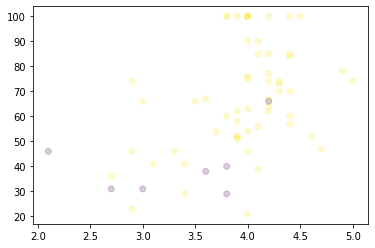

In [14]:
correct = hep_y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(hep_x_train[:,0], hep_x_train[:,1], c=hep_y_train, marker='o', alpha=.2, label='train')
plt.scatter(hep_x_test[correct,0], hep_x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(hep_x_test[incorrect,0], hep_x_test[incorrect,1], marker='x', c=hep_y_test[incorrect], label='misclassified')
plt.legend()
plt.show()

In [ ]:

data3 = arff.loadarff('./sample_data/messidor_features.arff')
data3 = pd.DataFrame(data3[0])
col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
            'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
            ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
            'euc_dist','diam_opt_disc','AM/FM','class_label']
data3.columns = col_names
data3.class_label = data3.class_label.apply(lambda x: pd.to_numeric(str(x)[2]))
data3 = data3.replace({'?' : np.nan}).dropna()
print(data3)




      qual_assess  pre_screen  ...  AM/FM  class_label
0             1.0         1.0  ...    1.0            0
1             1.0         1.0  ...    0.0            0
2             1.0         1.0  ...    0.0            1
3             1.0         1.0  ...    0.0            0
4             1.0         1.0  ...    0.0            1
...           ...         ...  ...    ...          ...
1146          1.0         1.0  ...    0.0            0
1147          1.0         1.0  ...    0.0            0
1148          1.0         0.0  ...    0.0            0
1149          1.0         1.0  ...    1.0            1
1150          1.0         1.0  ...    0.0            0

[1151 rows x 20 columns]


NameError: ignored